# The social network of Caesar's *Bellum Gallicum*

## Data Flow

The data will be collected from a reduced version (extracts) of the *Bellum Gallicum*, which has been manually annotated for morphology and syntax according to the Universal Dependency model, in the CoNLL-U format.

See the [GitHub repository](https://github.com/proiel/proiel-treebank/blob/master/caes-gal.conll).

### The components of the CoNLL-U annotation schema

CoNLL-U annotations are distributed as plain text files.

The annotation files contain three types of lines: **comment lines**, **word lines** and **blank lines**.

**Comment lines** precede word lines and start with a hash character (#). These lines can be used to provide metadata about the word lines that follow.

Each **word line** contains annotations for a single word or token. Larger linguistic units are represented by subsequent word lines.

The annotations for a word line are provided using the following fields, each separated by a tabulator character:

```console
ID	FORM	LEMMA	UPOS	XPOS	FEATS	HEAD	DEPREL	DEPS	MISC
```

 1. `ID`: Index of the word in sequence
 2. `FORM`: The form of a word or punctuation symbol
 3. `LEMMA`: Lemma or the base form of a word
 4. `UPOS`: [Universal part-of-speech tag](https://universaldependencies.org/u/pos/)
 5. `XPOS`: Language-specific part-of-speech tag
 6. `FEATS`: [Morphological features](https://universaldependencies.org/u/feat/index.html)
 7. `HEAD`: Syntactic head of the current word
 8. `DEPREL`: Universal dependency relation to the `HEAD`
 9. `DEPS`: [Enhanced dependency relations](https://universaldependencies.org/u/overview/enhanced-syntax.html)
 10. `MISC`: Any additional annotations

Finally, a **blank line** after word lines is used to separate sentences.

For reading and managing the CoNNL-U formatted file, we will use Python [conllu](https://pypi.org/project/conllu/) library.

In [1]:
# Import the conllu library
import conllu
from conllu.models import Token

In [2]:
# Open the plain text file for reading; assign under 'data'
with open('caes_gal.conllu', mode="r", encoding="utf-8") as data:

    # Read the file contents and assign under 'annotations'
    annotations = data.read()
# Use the parse() function to parse the annotations; store under 'sentences'
sentences = conllu.parse(annotations)

The parse() function returns a Python list populated by TokenList objects, native to pyconll library.

In [3]:
# print the first token (TokenList object) of the first sentence (list).
sentences[0][0]

{'id': 1,
 'form': 'Gallia',
 'lemma': 'Gallia',
 'upos': 'PROPN',
 'xpos': 'Ne',
 'feats': {'Case': 'Nom', 'Gender': 'Fem', 'Number': 'Sing'},
 'head': 4,
 'deprel': 'nsubj:pass',
 'deps': None,
 'misc': {'Ref': '1.1.1'}}

### Named Entities extraction

First of all, we want to extract the NE from the annotations. Although proper nouns are already marked as such in `annotations`, we don't need to perform an actual NE recognition. Nevertheless, since sentences are annotated token-by-token, in case of multi-token names we need to group the tokens that are associated with the same entity, i.e. are part of the full name of a character. To do so, we can rely on the consistency of the annotation procedure, for which the "second names" are marked as direct dependants of the "first name" token by a 'flat:name' relation.

In [4]:
def get_ne(sentences:list):
    full_names = []
    for sent in sentences:
        visited_tokens = []
        for token in sent:
            if token['xpos'] == 'Ne' and token not in visited_tokens:
                second_names = [t for t in sent if t['deprel'] == 'flat:name' and t['head'] == token['id'] and t not in visited_tokens]
                visited_tokens.append(token)
                if second_names:
                    multi_token_name = [token, *second_names] # the token corresponding to the "first name" at the beginning of the list
                    full_names.append(multi_token_name)
                    for t in second_names:
                        visited_tokens.append(t)
                else:
                    full_names.append([token])
    return full_names

In [5]:
ne_instances = get_ne(sentences)

In [6]:
ne_tok_instances_set = [l[0] for l in ne_instances]


In [7]:
ne_tok_instances_set

[{'id': 1,
  'form': 'Gallia',
  'lemma': 'Gallia',
  'upos': 'PROPN',
  'xpos': 'Ne',
  'feats': {'Case': 'Nom', 'Gender': 'Fem', 'Number': 'Sing'},
  'head': 4,
  'deprel': 'nsubj:pass',
  'deps': None,
  'misc': {'Ref': '1.1.1'}},
 {'id': 4,
  'form': 'Garumna',
  'lemma': 'Garumna',
  'upos': 'PROPN',
  'xpos': 'Ne',
  'feats': {'Case': 'Nom', 'Gender': 'Masc', 'Number': 'Sing'},
  'head': 1,
  'deprel': 'nsubj',
  'deps': None,
  'misc': {'Ref': '1.1.2'}},
 {'id': 8,
  'form': 'Matrona',
  'lemma': 'Matrona',
  'upos': 'PROPN',
  'xpos': 'Ne',
  'feats': {'Case': 'Nom', 'Gender': 'Masc', 'Number': 'Sing'},
  'head': 11,
  'deprel': 'nsubj',
  'deps': None,
  'misc': {'Ref': '1.1.2'}},
 {'id': 10,
  'form': 'Sequana',
  'lemma': 'Sequana',
  'upos': 'PROPN',
  'xpos': 'Ne',
  'feats': {'Case': 'Nom', 'Gender': 'Fem', 'Number': 'Sing'},
  'head': 8,
  'deprel': 'conj',
  'deps': None,
  'misc': {'Ref': '1.1.2'}},
 {'id': 36,
  'form': 'Rhenum',
  'lemma': 'Rhenus',
  'upos': 'PROPN'

In [8]:
import itertools
from pprint import pprint
from collections import defaultdict

In [9]:
from pprint import pprint
pprint(sentences[0].head_to_token(sentences[0]))

defaultdict(<class 'list'>,
            {0: [{'deprel': 'root',
                  'deps': None,
                  'feats': {'Aspect': 'Perf',
                            'Case': 'Nom',
                            'Gender': 'Fem',
                            'Number': 'Sing',
                            'Tense': 'Past',
                            'VerbForm': 'Part',
                            'Voice': 'Pass'},
                  'form': 'divisa',
                  'head': 0,
                  'id': 4,
                  'lemma': 'divido',
                  'misc': {'Ref': '1.1.1'},
                  'upos': 'VERB',
                  'xpos': 'V-'}],
             1: [{'deprel': 'det',
                  'deps': None,
                  'feats': {'Case': 'Nom',
                            'Gender': 'Fem,Masc',
                            'Number': 'Sing'},
                  'form': 'omnis',
                  'head': 1,
                  'id': 3,
                  'lemma': 'omnis',
          

In [10]:
def get_relations(sentences:list):

    global_relations = []
    # all_full_names = []
    for sent in sentences:
        relations_in_sentence = []
        entities_in_sent = []
        visited_tokens = []
        for token in sent:
            if token['upos'] == 'PROPN' and token not in visited_tokens:
                second_names = [t for t in sent if t['deprel'] == 'flat:name' and t['head'] == token['id'] and t not in visited_tokens]
                visited_tokens.append(token)
                if second_names:
                    fullname = [token, *second_names] # the token corresponding to the "first name" at the beginning of the list
                    # all_full_names.append(fullname)
                    entities_in_sent.append(fullname)
                    for t in second_names:
                        visited_tokens.append(t)
                else:
                    fullname = [token]
                    # all_full_names.append(fullname)
                    entities_in_sent.append(fullname)
                    visited_tokens.append(fullname)

        pairs = list(itertools.combinations(entities_in_sent, 2))

        for pair in pairs:
            ent1 = pair[0]
            ent2 = pair[1]
            value = 1


            if ent1[0]['head'] == ent2[0]['head'] or (ent1[0]['head'] == ent2[0]['id'] or ent2[0]['head'] == ent1[0]['id']):
                value += 2

            if value is not None:
                relation = {'ent1':ent1, 'ent2': ent2, 'value': value}
                relations_in_sentence.append(relation)

        if relations_in_sentence:
            global_relations.append(relations_in_sentence)

    return global_relations

In [11]:
def get_dependency_relations(sentences:list):

    global_relations = []
    # all_full_names = []
    for sent in sentences:

        relations_in_sentence = []
        entities_in_sent = []
        visited_tokens = []
        for token in sent:
            if token['upos'] == 'PROPN' and token not in visited_tokens:
                second_names = [t for t in sent if t['deprel'] == 'flat:name' and t['head'] == token['id'] and t not in visited_tokens]
                visited_tokens.append(token)
                if second_names:
                    fullname = [token, *second_names] # the token corresponding to the "first name" at the beginning of the list
                    # all_full_names.append(fullname)
                    entities_in_sent.append(fullname)
                    for t in second_names:
                        visited_tokens.append(t)
                else:
                    fullname = [token]
                    # all_full_names.append(fullname)
                    entities_in_sent.append(fullname)
                    visited_tokens.append(fullname)

        pairs = list(itertools.combinations(entities_in_sent, 2))

        for pair in pairs:
            ent1 = pair[0]
            ent2 = pair[1]
            value = None

            # if ent1[0]['head']-1 >= 0:
            #     ent1_head_idx = ent1[0]['head']-1
            # else:
            #     sent_root_idx = None
            #     for idx, t in enumerate(range(len(sent))):
            #         if t['deprel'] == 'root':
            #             sent_root_idx = sent[idx]
            #     ent1_head_idx = sent_root_idx
            #
            # if ent2[0]['head']-1 >= 0:
            #     ent2_head_idx = ent2[0]['head']-1
            # else:
            #     sent_root_idx = None
            #     for idx, t in enumerate(range(len(sent))):
            #         if t['deprel'] == 'root':
            #             sent_root_idx = sent[idx]
            #     ent2_head_idx = sent_root_idx

            # -------------------------------------------

            if ent1[0]['head'] == ent2[0]['head']: # same head
                value = 3

            if ent1[0]['head'] == ent2[0]['id'] or ent2[0]['head'] == ent1[0]['id']:
                value = 2

            else:
                try:
                    if ent1[0]['head'] == sent[ent2[0]['head']-1]['head'] or ent2[0]['head'] == sent[ent1[0]['head']-1]['head']:
                        value = 1

                    elif sent[ent1[0]['head']-1]['head'] == sent[ent2[0]['head']-1]['head']: # share grandparent
                        value = 0.5

                except IndexError: # one of the heads is the root
                    continue


            if value is not None:
                relation = {'ent1':ent1, 'ent2': ent2, 'value': value}
                relations_in_sentence.append(relation)

        if relations_in_sentence:
            global_relations.append(relations_in_sentence)

    return global_relations

In [12]:
relations_instances = get_dependency_relations(sentences)
# relations_instances = get_relations(sentences)

relations_instances

[[{'ent1': [{'id': 4,
     'form': 'Garumna',
     'lemma': 'Garumna',
     'upos': 'PROPN',
     'xpos': 'Ne',
     'feats': {'Case': 'Nom', 'Gender': 'Masc', 'Number': 'Sing'},
     'head': 1,
     'deprel': 'nsubj',
     'deps': None,
     'misc': {'Ref': '1.1.2'}}],
   'ent2': [{'id': 8,
     'form': 'Matrona',
     'lemma': 'Matrona',
     'upos': 'PROPN',
     'xpos': 'Ne',
     'feats': {'Case': 'Nom', 'Gender': 'Masc', 'Number': 'Sing'},
     'head': 11,
     'deprel': 'nsubj',
     'deps': None,
     'misc': {'Ref': '1.1.2'}}],
   'value': 1},
  {'ent1': [{'id': 8,
     'form': 'Matrona',
     'lemma': 'Matrona',
     'upos': 'PROPN',
     'xpos': 'Ne',
     'feats': {'Case': 'Nom', 'Gender': 'Masc', 'Number': 'Sing'},
     'head': 11,
     'deprel': 'nsubj',
     'deps': None,
     'misc': {'Ref': '1.1.2'}}],
   'ent2': [{'id': 10,
     'form': 'Sequana',
     'lemma': 'Sequana',
     'upos': 'PROPN',
     'xpos': 'Ne',
     'feats': {'Case': 'Nom', 'Gender': 'Fem', 'Number':

## Process relations instances

In the script below, the list of relations, in which each entity's occurence is represented by its TokenList object, is processed to obtain a list of tuples, `final_relations`, each of which consists in the weighted edge of the graph that will be built.

In [13]:
tmp_relations = []
for rels_in_sent in relations_instances:

    for rel in rels_in_sent:

        ent1 = ' '.join([i['lemma'] for i in rel['ent1']])
        ent2 = ' '.join([i['lemma'] for i in rel['ent2']])

        value = rel['value']

        row = (ent1, ent2, value)
        tmp_relations.append(row)

# create a defaultdict to store the sums
sums = defaultdict(int)

# loop through the tuples and add the third element to the sum
# for the corresponding first two elements
for t in tmp_relations:
    sums[(t[0], t[1])] += t[2]

# create a new list of tuples with the first two elements as the key
# and the sum as the value
final_relations = [(k[0], k[1], v) for k, v in sums.items()]
final_relations = [rel for rel in final_relations if rel[0] != rel[1]]

In [14]:
final_relations

[('Garumna', 'Matrona', 1),
 ('Matrona', 'Sequana', 2),
 ('Marcus Messala', 'Marcus Piso', 4),
 ('Rhenus', 'Lemannus', 0.5),
 ('Lemannus', 'Rhodanus', 1.5),
 ('Rhenus', 'Noreia', 1),
 ('Iura', 'Rhodanus', 1),
 ('Lucius Piso', 'Aulus Gabinius', 2),
 ('Caesar', 'Gallia', 4.5),
 ('Caesar', 'Genava', 0.5),
 ('Gallia', 'Genava', 0.5),
 ('Nammeius', 'Verucloetius', 2),
 ('Lemannus', 'Iura', 0.5),
 ('Gallia', 'Alpis', 0.5),
 ('Arar', 'Rhodanus', 1),
 ('Caesar', 'Lucius Piso', 1),
 ('Caesar', 'Tigurinus', 1),
 ('Lucius Piso', 'Tigurinus', 0.5),
 ('Diviciacus', 'Liscus', 2),
 ('Caesar', 'Dumnorix', 4),
 ('Liscus', 'Dumnorix', 1),
 ('Diviciacus', 'Gaius Valerius Troucillus', 0.5),
 ('Diviciacus', 'Caesar', 1),
 ('Lucius Sulla', 'Marcus Crassus', 0.5),
 ('Labienus', 'Considius', 1),
 ('Labienus', 'Caesar', 1),
 ('Gallia', 'Caesar', 2.5),
 ('Rhenus', 'Gallia', 1.5),
 ('Nasua', 'Cimberius', 2),
 ('Ariovistus', 'Vesentio', 1),
 ('Ariovistus', 'Caesar', 3.5),
 ('Gallia', 'Ariovistus', 2),
 ('Ariovist

#### Create and process the entities that appear in at least one interaction and are actual people

In [15]:
import json

# create list of entities that are involved in a relation
entities = list(sorted({name for rel in final_relations for name in rel if type(name) == str}))

# assign to a variable the list of all places in Latin literature
# places_list = json.loads('places.json')

with open('places.json') as json_file:
   places_list = json.load(json_file)

# filter entities list
people_entities = list(filter(lambda x: x not in places_list, entities))
people_relations = list(filter(lambda x: x[0] not in places_list and x[1] not in places_list, final_relations))

In [16]:
people_relations

[('Marcus Messala', 'Marcus Piso', 4),
 ('Lucius Piso', 'Aulus Gabinius', 2),
 ('Nammeius', 'Verucloetius', 2),
 ('Caesar', 'Lucius Piso', 1),
 ('Diviciacus', 'Liscus', 2),
 ('Caesar', 'Dumnorix', 4),
 ('Liscus', 'Dumnorix', 1),
 ('Diviciacus', 'Gaius Valerius Troucillus', 0.5),
 ('Diviciacus', 'Caesar', 1),
 ('Lucius Sulla', 'Marcus Crassus', 0.5),
 ('Labienus', 'Considius', 1),
 ('Labienus', 'Caesar', 1),
 ('Nasua', 'Cimberius', 2),
 ('Ariovistus', 'Vesentio', 1),
 ('Ariovistus', 'Caesar', 3.5),
 ('Gaius Valerius Procillus', 'Marcus Metius', 0.5),
 ('Gaius Valerius Caburus', 'Gaius Valerius', 0.5),
 ('Caesar', 'Ariovistus', 1),
 ('Gaius Valerius Procillus', 'Caesar', 0.5),
 ('Caesar', 'Titurius', 1.5),
 ('Quintus Pedius', 'Lucius Aurunculeius Cotta', 2),
 ('Caesar', 'Servius Galba', 1),
 ('Publius Sextius Baculus', 'Gaius Volusenus', 2),
 ('Publius Sextius Baculus', 'Galba', 0.5),
 ('Gaius Volusenus', 'Galba', 1),
 ('Titus Terrasidius', 'Marcus Trebius', 0.5),
 ('Titus Terrasidius', 

## Let's build the graph!

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
from pprint import pprint

edges = people_relations
nodes = people_entities

G = nx.Graph()

# for n in nodes:
#     G.add_node(n)

for item in edges:
    G.add_edge(item[0], item[1], weight=item[2])

In [36]:
print('Number of nodes: ', G.number_of_nodes())
print('Number of edges: ', G.number_of_edges())

Number of nodes:  70
Number of edges:  70
70
70


In [19]:
print(G.edges().data())

[('Marcus Messala', 'Marcus Piso', {'weight': 4}), ('Lucius Piso', 'Aulus Gabinius', {'weight': 2}), ('Lucius Piso', 'Caesar', {'weight': 1}), ('Nammeius', 'Verucloetius', {'weight': 2}), ('Caesar', 'Dumnorix', {'weight': 2}), ('Caesar', 'Diviciacus', {'weight': 1}), ('Caesar', 'Labienus', {'weight': 0.5}), ('Caesar', 'Ariovistus', {'weight': 1}), ('Caesar', 'Gaius Valerius Procillus', {'weight': 0.5}), ('Caesar', 'Titurius', {'weight': 1.5}), ('Caesar', 'Servius Galba', {'weight': 1}), ('Caesar', 'Crassus', {'weight': 1}), ('Caesar', 'Sabinus', {'weight': 1}), ('Caesar', 'Volusenus', {'weight': 0.5}), ('Caesar', 'Titus Labienus', {'weight': 0.5}), ('Caesar', 'Quintus Titurius', {'weight': 0.5}), ('Caesar', 'Lucius Cotta', {'weight': 1}), ('Caesar', 'Lucius Domitius', {'weight': 1}), ('Caesar', 'Indutiomarus', {'weight': 0.5}), ('Caesar', 'Marcus Silanus', {'weight': 1}), ('Caesar', 'Gaius Fabius', {'weight': 1}), ('Caesar', 'Durocortorum', {'weight': 0.5}), ('Caesar', 'Acco', {'weight

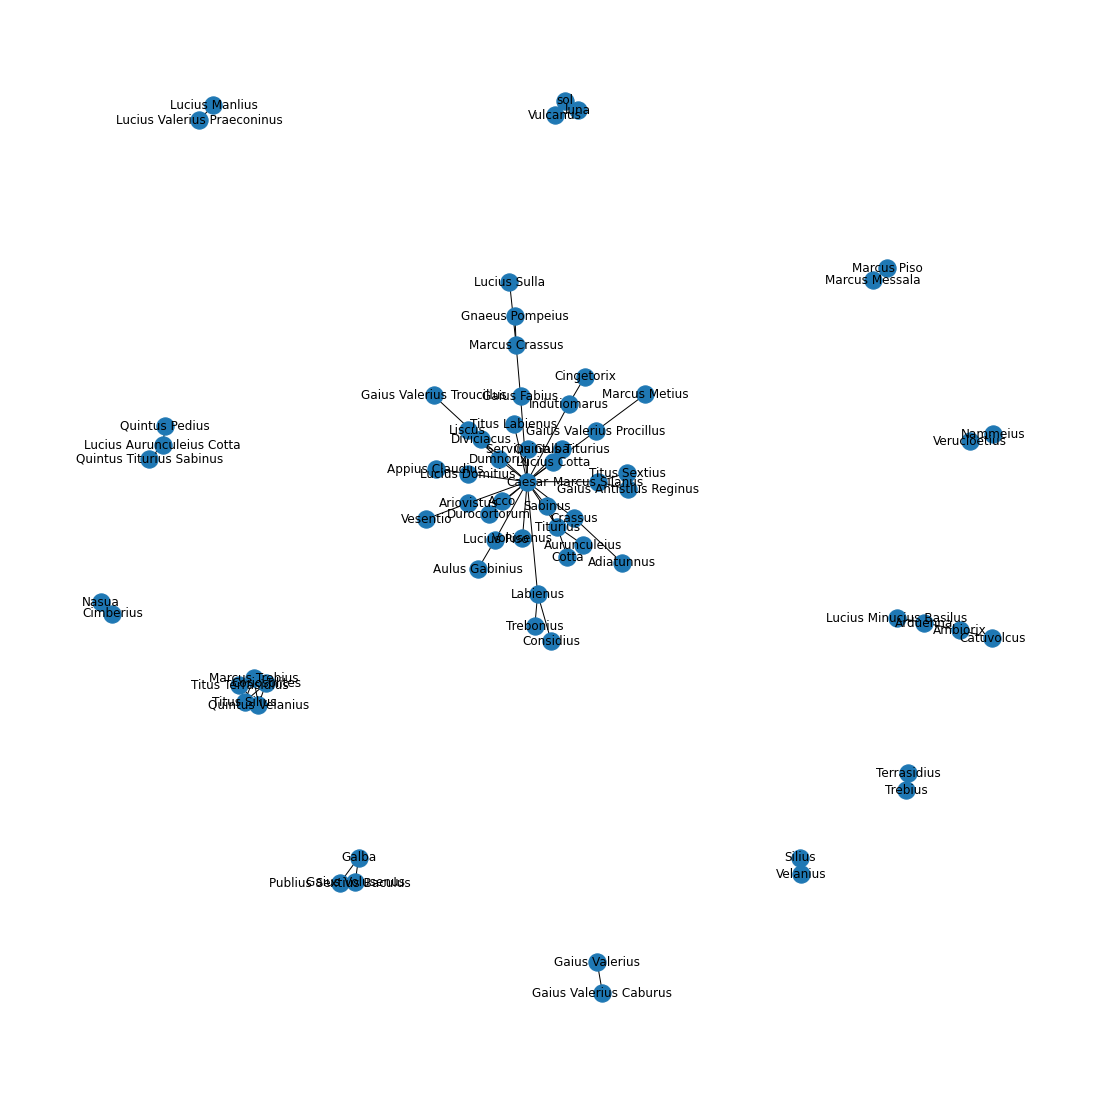

In [20]:
# VISUALIZATION
plt.figure(figsize=(15,15))
nx.draw(G, with_labels=True) # with_labels=True for showing node's label
plt.show()

In [21]:
# from pyvis.network import Network
#
# net = Network(notebook=True, width="1000px", height="700px", bgcolor="#222222", font_color='white')
#
# net.from_nx(G)
# net.show("caes_net.html")

In [22]:
nx.write_gexf(G, "gephi_net.gexf")

## Measures

##### Find cliques

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.clique.find_cliques.html#networkx.algorithms.clique.find_cliques

In [23]:
cliques_list = (sorted(list(nx.find_cliques(G)), key=lambda x: len(x), reverse=True))
cliques_list

[['Quintus Velanius',
  'Marcus Trebius',
  'Titus Terrasidius',
  'Titus Silius',
  'Coriosolites'],
 ['Vulcanus', 'luna', 'sol'],
 ['Gaius Volusenus', 'Publius Sextius Baculus', 'Galba'],
 ['Gaius Antistius Reginus', 'Titus Sextius', 'Marcus Silanus'],
 ['Caesar', 'Titurius', 'Sabinus'],
 ['Caesar', 'Lucius Cotta', 'Quintus Titurius'],
 ['Caesar', 'Durocortorum', 'Acco'],
 ['Terrasidius', 'Trebius'],
 ['Marcus Crassus', 'Gaius Fabius'],
 ['Marcus Crassus', 'Lucius Sulla'],
 ['Marcus Crassus', 'Gnaeus Pompeius'],
 ['Aulus Gabinius', 'Lucius Piso'],
 ['Cimberius', 'Nasua'],
 ['Marcus Messala', 'Marcus Piso'],
 ['Gaius Valerius', 'Gaius Valerius Caburus'],
 ['Liscus', 'Diviciacus'],
 ['Liscus', 'Dumnorix'],
 ['Quintus Pedius', 'Lucius Aurunculeius Cotta'],
 ['Appius Claudius', 'Lucius Domitius'],
 ['Catuvolcus', 'Ambiorix'],
 ['Nammeius', 'Verucloetius'],
 ['Ambiorix', 'Arduenna'],
 ['Quintus Titurius Sabinus', 'Lucius Aurunculeius Cotta'],
 ['Considius', 'Labienus'],
 ['Silius', 'Velan

##### Degree, degree centrality and closeness centrality

In order to understand if the most important character in the work are represented as such in the graph, we can look at the node's degree, degree centrality and closeness centrality. These measures are relevant on the assumption that important actors are involved in a higher number of interactions with others, and that they are able to communicate more easily with most of the nodes.

In [24]:
degrees = nx.degree(G) # high number of interactions for important nodes
degree_centrality = nx.degree_centrality(G) # more interactions for important nodes
closeness_centrality = nx.closeness_centrality(G) # easy communication of important nodes

In [25]:
# DEGREE
print(sorted(degrees, key=lambda x: x[1], reverse=True))

[('Caesar', 20), ('Titurius', 4), ('Titus Terrasidius', 4), ('Marcus Trebius', 4), ('Coriosolites', 4), ('Quintus Velanius', 4), ('Titus Silius', 4), ('Diviciacus', 3), ('Marcus Crassus', 3), ('Labienus', 3), ('Marcus Silanus', 3), ('Lucius Piso', 2), ('Liscus', 2), ('Dumnorix', 2), ('Ariovistus', 2), ('Gaius Valerius Procillus', 2), ('Lucius Aurunculeius Cotta', 2), ('Publius Sextius Baculus', 2), ('Gaius Volusenus', 2), ('Galba', 2), ('Crassus', 2), ('Sabinus', 2), ('Quintus Titurius', 2), ('Lucius Cotta', 2), ('Lucius Domitius', 2), ('Indutiomarus', 2), ('Gaius Antistius Reginus', 2), ('Titus Sextius', 2), ('Gaius Fabius', 2), ('sol', 2), ('Vulcanus', 2), ('luna', 2), ('Ambiorix', 2), ('Arduenna', 2), ('Durocortorum', 2), ('Acco', 2), ('Marcus Messala', 1), ('Marcus Piso', 1), ('Aulus Gabinius', 1), ('Nammeius', 1), ('Verucloetius', 1), ('Gaius Valerius Troucillus', 1), ('Lucius Sulla', 1), ('Considius', 1), ('Nasua', 1), ('Cimberius', 1), ('Vesentio', 1), ('Marcus Metius', 1), ('Ga

In [26]:
# DEGREE CENTRALITY
print(sorted(degree_centrality.items(), key=lambda x:x[1], reverse=True))

[('Caesar', 0.2898550724637681), ('Titurius', 0.057971014492753624), ('Titus Terrasidius', 0.057971014492753624), ('Marcus Trebius', 0.057971014492753624), ('Coriosolites', 0.057971014492753624), ('Quintus Velanius', 0.057971014492753624), ('Titus Silius', 0.057971014492753624), ('Diviciacus', 0.043478260869565216), ('Marcus Crassus', 0.043478260869565216), ('Labienus', 0.043478260869565216), ('Marcus Silanus', 0.043478260869565216), ('Lucius Piso', 0.028985507246376812), ('Liscus', 0.028985507246376812), ('Dumnorix', 0.028985507246376812), ('Ariovistus', 0.028985507246376812), ('Gaius Valerius Procillus', 0.028985507246376812), ('Lucius Aurunculeius Cotta', 0.028985507246376812), ('Publius Sextius Baculus', 0.028985507246376812), ('Gaius Volusenus', 0.028985507246376812), ('Galba', 0.028985507246376812), ('Crassus', 0.028985507246376812), ('Sabinus', 0.028985507246376812), ('Quintus Titurius', 0.028985507246376812), ('Lucius Cotta', 0.028985507246376812), ('Lucius Domitius', 0.0289855

In [27]:
# CLOSENESS CENTRALITY
print(sorted(closeness_centrality.items(), key=lambda x:x[1], reverse=True))

[('Caesar', 0.354296066252588), ('Gaius Fabius', 0.23070441523424337), ('Titurius', 0.22805264034649342), ('Diviciacus', 0.22546113306982876), ('Labienus', 0.22546113306982876), ('Marcus Silanus', 0.22546113306982876), ('Sabinus', 0.2229278619117408), ('Lucius Piso', 0.22045088566827697), ('Dumnorix', 0.22045088566827697), ('Ariovistus', 0.22045088566827697), ('Gaius Valerius Procillus', 0.22045088566827697), ('Crassus', 0.22045088566827697), ('Lucius Domitius', 0.22045088566827697), ('Indutiomarus', 0.22045088566827697), ('Quintus Titurius', 0.2180283484631311), ('Lucius Cotta', 0.2180283484631311), ('Durocortorum', 0.2180283484631311), ('Acco', 0.2180283484631311), ('Servius Galba', 0.21565847511027098), ('Volusenus', 0.21565847511027098), ('Titus Labienus', 0.21565847511027098), ('Marcus Crassus', 0.16814050601817737), ('Liscus', 0.16262770254217154), ('Gaius Antistius Reginus', 0.16130552609873927), ('Titus Sextius', 0.16130552609873927), ('Aurunculeius', 0.16130552609873927), ('Co

##### Eigenvector centrality
The value of the Eigenvector centrality (centrality of a node based on the centrality of its neighbors) of each node can be interpreted as a measure of how “important” is each individual, since we would expect that “important” individuals (such as Caesar and other Roman generals) interact more frequently with other important individuals than they do with “minor” actors

In [28]:
# EIGENVECTOR CENTRALITY
eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')
print(sorted(eigenvector_centrality.items(), key=lambda x:x[1], reverse=True))

[('Caesar', 0.6233813943128695), ('Titurius', 0.33838504663555286), ('Dumnorix', 0.2777116766763103), ('Marcus Silanus', 0.19753296395903577), ('Sabinus', 0.19419598690676032), ('Lucius Cotta', 0.18076515938903023), ('Diviciacus', 0.179642417166033), ('Gaius Fabius', 0.15680126189165644), ('Lucius Piso', 0.15039750410627906), ('Lucius Domitius', 0.15039750410627906), ('Acco', 0.14446827280311098), ('Aurunculeius', 0.13665067791240715), ('Cotta', 0.13665067791240715), ('Quintus Titurius', 0.1359340626186419), ('Ariovistus', 0.1312205151558989), ('Liscus', 0.1286197572062702), ('Crassus', 0.12716679717887722), ('Servius Galba', 0.12587064795055675), ('Durocortorum', 0.09210577287237359), ('Gaius Antistius Reginus', 0.08872790267584499), ('Titus Sextius', 0.08872790267584499), ('Labienus', 0.07904960681358593), ('Marcus Crassus', 0.07659279407956203), ('Indutiomarus', 0.0751987520531396), ('Gaius Valerius Procillus', 0.06358339858943861), ('Volusenus', 0.06293532397527837), ('Titus Labien

##### Betweenness centrality and centralization
We compute betweennes centrality and see if a small number of nodes have much higher degree centrality values than the others  --> we plot a histogram!!

In [29]:
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
betweenness_centrality

{'Marcus Messala': 0.0,
 'Marcus Piso': 0.0,
 'Lucius Piso': 0.015345268542199489,
 'Aulus Gabinius': 0.0,
 'Nammeius': 0.0,
 'Verucloetius': 0.0,
 'Caesar': 0.2710997442455243,
 'Diviciacus': 0.022591645353793693,
 'Liscus': 0.00042625745950554135,
 'Dumnorix': 0.007246376811594203,
 'Gaius Valerius Troucillus': 0.0,
 'Lucius Sulla': 0.0,
 'Marcus Crassus': 0.030264279624893437,
 'Labienus': 0.030264279624893437,
 'Considius': 0.0,
 'Nasua': 0.0,
 'Cimberius': 0.0,
 'Ariovistus': 0.015345268542199489,
 'Vesentio': 0.0,
 'Gaius Valerius Procillus': 0.015345268542199489,
 'Marcus Metius': 0.0,
 'Gaius Valerius Caburus': 0.0,
 'Gaius Valerius': 0.0,
 'Titurius': 0.030264279624893437,
 'Quintus Pedius': 0.0,
 'Lucius Aurunculeius Cotta': 0.00042625745950554135,
 'Servius Galba': 0.0,
 'Publius Sextius Baculus': 0.0,
 'Gaius Volusenus': 0.0,
 'Galba': 0.00042625745950554135,
 'Titus Terrasidius': 0.0002841716396703609,
 'Marcus Trebius': 0.00014208581983518045,
 'Coriosolites': 0.000142085

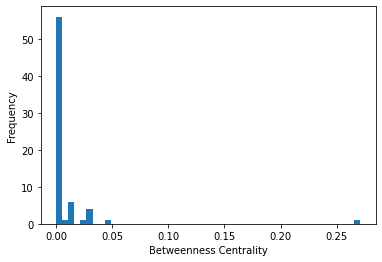

In [30]:
# Extract the betweenness centrality values from the dictionary
betweenness_centrality_values = list(betweenness_centrality.values())

# Create a histogram of the betweenness centrality values
plt.hist(betweenness_centrality_values, bins=50)
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.savefig("out/betweenness_centrality_hist.png")
plt.savefig("out/betweenness_centrality_hist.svg")
plt.show()

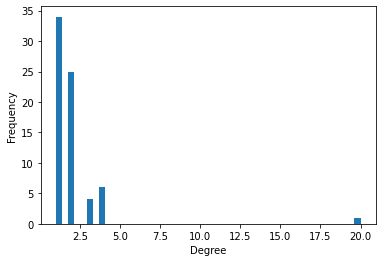

In [31]:
degree_list = [d[1] for d in list(nx.degree(G))]
plt.hist(degree_list, bins=50)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig("out/degree_hist.png")
plt.savefig("out/degree_hist.svg")
plt.show()

In [32]:
density = nx.density(G)
# diameter = nx.diameter() # not possible, since the graph is disconnected https://stackoverflow.com/a/69636529/20184608
clustering_coefficient = nx.clustering(G, weight='weight')

In [33]:
# print(sorted(clustering_coefficient.items(), key=lambda x:x[1], reverse=True))


In [34]:
import pandas as pd

adj_matrix = nx.adjacency_matrix(G)
adj_matrix_df = pd.DataFrame.sparse.from_spmatrix(adj_matrix)

C:\Users\media\AppData\Local\Temp/ipykernel_10784/2379880176.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G)
